In [2]:
import pandas as pd
import numpy as np

## Load data from CSV file in Kaggle website

In [3]:
# Get data from csv file
df = pd.read_csv('../data/fraud_dataset.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.shape

(6362620, 11)

In [5]:
# Take 100_000 rows in dataset
df = df[0:100_000]
df.shape

(100000, 11)

## Data Visualization and pre-processing

In [6]:
# Check null values in dataset
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
# Exploring transaction type
df.type.value_counts()

PAYMENT     39512
CASH_OUT    30718
CASH_IN     20185
TRANSFER     8597
DEBIT         988
Name: type, dtype: int64

In [8]:
# Exploring the amount of fraud
df.isFraud.value_counts()

0    99884
1      116
Name: isFraud, dtype: int64

In [9]:
# Show pie chart for transaction type
types = df.type.value_counts()
trans_types = types.index
trans_amounts = types.values

import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=trans_types, values=trans_amounts, hole=.3)])
fig.update_layout(title_text='Distribution of Transaction Types')
fig.show()

In [10]:
# Find the correlation between the features of data with isFraud column
correlation = df.corr(method='pearson')
correlation['isFraud'].sort_values(ascending=False)

isFraud           1.000000
amount            0.036422
oldbalanceOrg    -0.004144
newbalanceDest   -0.006394
oldbalanceDest   -0.009266
newbalanceOrig   -0.010872
step             -0.051329
isFlaggedFraud         NaN
Name: isFraud, dtype: float64

In [11]:
df.groupby(['type'])['isFraud'].value_counts(normalize=True)

type      isFraud
CASH_IN   0          1.000000
CASH_OUT  0          0.998079
          1          0.001921
DEBIT     0          1.000000
PAYMENT   0          1.000000
TRANSFER  0          0.993370
          1          0.006630
Name: isFraud, dtype: float64

## One hot encoding

In [12]:
# Transfer the categorical transaction type into numerical for better understanding
features = df[['amount', 'oldbalanceOrg', 'newbalanceOrig']]
features = pd.concat([features, pd.get_dummies(df['type'])], axis=1)
features.head()

,amount,oldbalanceOrg,newbalanceOrig,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,9839.64,170136.0,160296.36,0,0,0,1,0
1,1864.28,21249.0,19384.72,0,0,0,1,0
2,181.00,181.0,0.00,0,0,0,0,1
3,181.00,181.0,0.00,0,1,0,0,0
4,11668.14,41554.0,29885.86,0,0,0,1,0


## Normalize Data

In [13]:
# split data into training and testing set
from sklearn.model_selection import train_test_split
x = features
y = np.array(df['isFraud'])

In [14]:
# Data Standardization give data zero mean and unit variance (technically should be done after train test split )

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.1, random_state=4)
print('Train set: ', xtrain.shape, ytrain.shape)
print('Test set: ', xtest.shape, ytest.shape)

Train set:  (90000, 8) (90000,)
Test set:  (10000, 8) (10000,)


## Classification : use training set to build an accurate model

In [15]:
# Function to plot the Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax);
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['not fraud', 'fraud']); ax.yaxis.set_ticklabels(['not fraud', 'fraud'])

### Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [17]:
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(xtrain, ytrain)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [18]:
tree_score = tree_cv.score(xtest, ytest)
print(tree_score)

0.9986


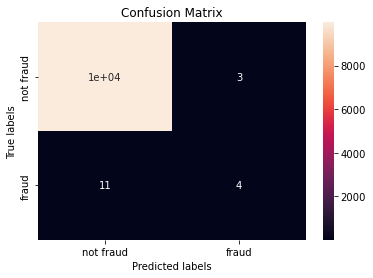

In [19]:
# Plot the confusion matrix for Decision Tree
yhat = tree_cv.predict(xtest)
plot_confusion_matrix(ytest, yhat)

In [20]:
print(f'The best parameter: {tree_cv.best_params_}')
print(f'The accuracy: {tree_cv.best_score_}')

The best parameter: {'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
The accuracy: 0.9990555555555554


In [22]:
xtrain[0:2]

,amount,oldbalanceOrg,newbalanceOrig,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
42483,4434.89,0.0,0.0,0,0,0,1,0
17274,1778.27,0.0,0.0,0,0,0,0,1


In [23]:
# Check a transaction is fraud or not
transaction = np.array([[9000.50, 1000.50, 0.0, 0, 0, 0, 0, 1]])
yhat = tree_cv.predict(transaction)
yhat

/Users/tienpham/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



array([0])